# Primary model experiments

This notebook intends to test the models specified in the file `preliminary_model.pdf` to estimate prevalence. 

In [18]:
import numpy as np
import pandas as pd
import pystan as ps
from scipy.special import logit, expit

import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az

import pickle
from tqdm.notebook import tqdm

sns.set()
plt.rc('mathtext', fontset="cm")
ro = np.random.RandomState(1000)
%matplotlib inline

## Perfect tests

In [2]:
compiled = True

In [4]:
if compiled: 
    sm = pickle.load(open('pickles/perfect_test.pkl', 'rb'))
else: 
    sm = ps.StanModel(file = 'stan_codes/perfect_test.stan')
    with open('pickles/perfect_test.pkl', 'wb') as f:
        pickle.dump(sm, f)

### Data

First we describe data created artificially. 

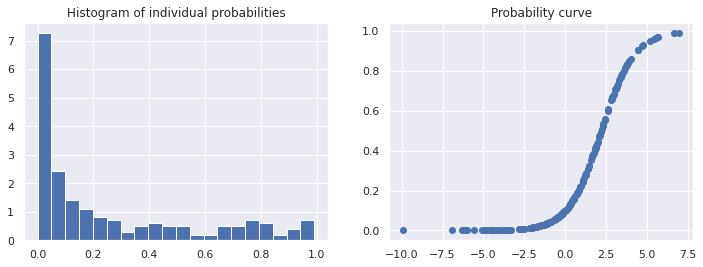

In [5]:
n_samples    = 200
n_predictors = 5  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors+1), 
                           cov = np.eye(n_predictors+1),
                           size = n_samples) 

beta = np.array([0.5, 0.1, 2.5, -1.0, 1.2, 0.3]).reshape(-1,1)
prevalence = 0.1

theta = expit(logit(prevalence) + x@beta)

T = ro.binomial(n = 1, p = theta)

fig, ax = plt.subplots(1,2,figsize=(12,4))

ax[0].hist(theta, density = True, bins = 20)
ax[1].scatter(x@beta, theta)

ax[0].set_title('Histogram of individual probabilities')
ax[1].set_title('Probability curve')

plt.show()

In [6]:
data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "T"            : T.flatten(),
    "x"            : x,
}

T.mean()

0.265

Now we describe the necessary pieces to the model. 

In [7]:
Sigma   = np.eye(6)
mu      = np.zeros(6)
alpha_p = 1
beta_p  = 3

data.update({
    "Sigma"        : Sigma,
    "mu"           : mu,
    "alpha_p"      : alpha_p,
    "beta_p"       : beta_p
})

And we apply it to the sampling.

In [8]:
fit = sm.sampling(data=data)

In [9]:
print(fit)

Inference for Stan model: anon_model_00a8c0834a37af1dc353c25afbc75fe4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

                   mean se_mean     sd   2.5%    25%     50%    75%  97.5%  n_eff   Rhat
effects[1]         0.27  3.2e-3   0.22  -0.16   0.13    0.27   0.42   0.72   4707    1.0
effects[2]         0.21  3.0e-3   0.23  -0.23   0.05    0.21   0.37   0.66   5969    1.0
effects[3]         2.49  6.0e-3   0.35   1.85   2.25    2.49   2.73    3.2   3387    1.0
effects[4]        -1.07  4.3e-3   0.28  -1.64  -1.26   -1.06  -0.88  -0.55   4247    1.0
effects[5]         0.78  3.8e-3   0.24   0.33   0.62    0.78   0.94   1.25   3854    1.0
effects[6]         0.03  2.7e-3    0.2  -0.36   -0.1    0.03   0.17   0.44   5443    1.0
prev               0.12  5.2e-4   0.03   0.07    0.1    0.12   0.14   0.18   3270    1.0
effects_prior[1]  -0.01    0.02   0.98  -1.99  -0.66 -5.2e-3   0.64   1.91   4034    1.0
effects_pr

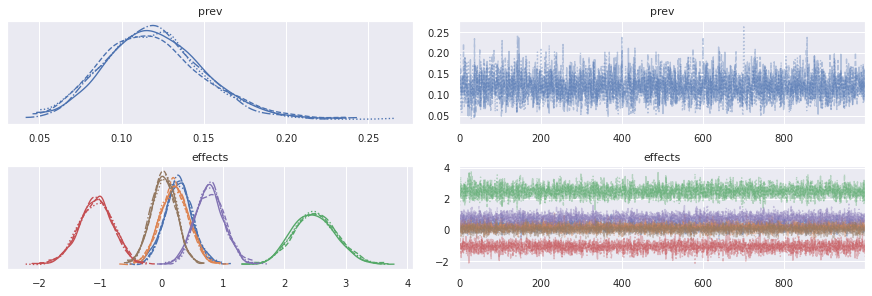

In [10]:
az.plot_trace(fit, var_names=('prev', 'effects'))
plt.show()

## Practical identifiability

Varying $\beta_1$ value (the intercept) with prevalence fixed. 

In [24]:
n_samples    = 100
n_predictors = 1  
  
x = ro.multivariate_normal(mean = np.zeros(n_predictors+1), 
                           cov = np.eye(n_predictors+1),
                           size = n_samples) 

prevalence = 0.1

data = {
    "n_samples"    : n_samples,
    "n_predictors" : n_predictors,
    "x"            : x,  
    "Sigma"        : np.eye(2), 
    "mu"           : np.zeros(2),
    "alpha_p"      : 1, 
    "beta_p"       : 3,
    "T"            : 0
}

values = []

for each in range(100): 
    
    beta = np.array([1.0, np.random.uniform(-2,2)]).reshape(-1,1)
    theta = expit(logit(prevalence) + x@beta)
    T = ro.binomial(n = 1, p = theta)
    
    data.update({
        "T"            : T.flatten(),
    })

    fit = sm.sampling(data=data)
        
    prev_estimated = fit.extract()['prev'].mean()
        
    values.append((beta, prev_estimated))

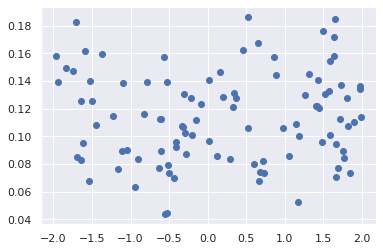

In [38]:
plt.scatter([i[0][1,0] for i in values], [i[1] for i in values])
plt.show()

(array([0.45677783, 0.58576069, 0.74129517, 0.98030974, 1.31010483,
        1.54016885, 1.47486487, 1.20327332, 0.94568263, 0.76237146]),
 array([4.65378246e-05, 1.00040444e-01, 2.00034351e-01, 3.00028257e-01,
        4.00022163e-01, 5.00016070e-01, 6.00009976e-01, 7.00003883e-01,
        7.99997789e-01, 8.99991695e-01, 9.99985602e-01]),
 <BarContainer object of 10 artists>)

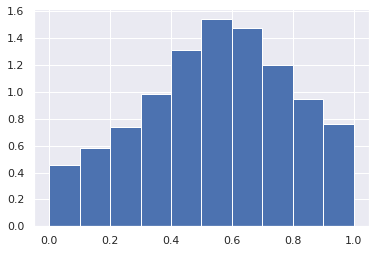

In [93]:
ind_prior = expit((fit.extract()['prev_prior'] + x@fit.extract()['effects_prior'].T)).flatten()
plt.hist(ind_prior, density = True)